max_depth: 4 => train data score: 0.815 val data score: 0.734


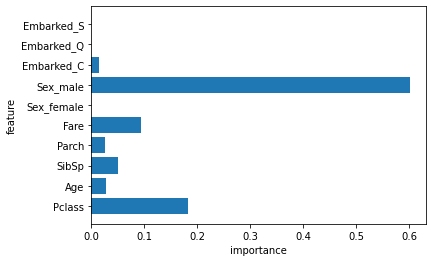

max_depth: 5 => train data score: 0.844 val data score: 0.762


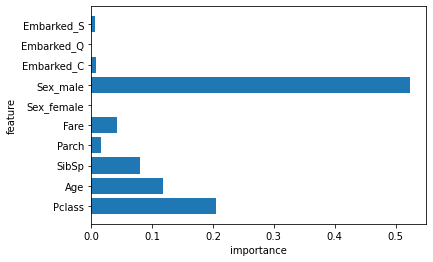

max_depth: 6 => train data score: 0.844 val data score: 0.804


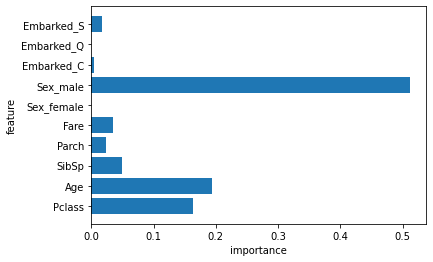

In [29]:
import pandas as pd
import libs.simple_processing as pds
import libs.simpleplotter as plot
from sklearn.tree import DecisionTreeClassifier

results = {}
# Read the data
X = pd.read_csv('input/train.csv')
X_test_full = pd.read_csv('input/test.csv')

# clean data
# Ticket - 681 unikalnych, prawie jak Name
# Cabin - 204 rekordy, duże braki
# , 'Parch', 'Embarked' - wg feature importance - można usunąć, ale usunięcie powoduje pogorszenie wyników
# 'PassengerId', powoduje przetrenowanie (train data: 1.000 val data: 0.839)

def process_data(df):
    cols = ['Name', 'Cabin', 'Ticket', 'PassengerId']
    df.drop(cols, axis=1, inplace=True)
    # usuwamy rekordy z brakującymi danymi
    df.dropna(axis=0, subset=df.columns, inplace=True)


process_data(X)
process_data(X_test_full)

# separate target from predictors
X, y = pds.separate_target(X, 'Survived')

# Splitting into train and validation data 80 / 20
X_train_full, X_valid_full, y_train, y_valid = pds.split_train_test(X, y)

X_train, X_valid, X_test = pds.categorical_numerical_cols(X_train_full, X_valid_full, X_test_full)
X_test.dropna(axis=0, subset=X_test.columns, inplace=True)

for md in range(4, 7, 1):
    model = DecisionTreeClassifier(max_depth=md, random_state=0, max_features="auto")
    model.fit(X_train, y_train)
    # plot.decision_tree(model, X_train)
    print('max_depth: {:.0f}'.format(md)
          + ' => train data score: {:.3f}'.format(model.score(X_train, y_train))
          + ' val data score: {:.3f}'.format(model.score(X_valid, y_valid)))
    plot.feature_importance(model, X_train)


In [30]:
import re
from sklearn.model_selection import GridSearchCV

# helper function to retrieve model name from model object
def get_model_name(trained_model_obj):
    reg = re.compile('([A-Za-z]+)\(')
    return reg.findall(trained_model_obj.__str__())[0]


params = [
    {
        'model': DecisionTreeClassifier(random_state=0, max_features="auto"),
        'hyperparams': {
            'max_depth': range(4, 7, 1)
        }
    }
]

grid_model = {}

# also tried to use cv=4 and 6-15 but it made results worse

for p in params:
    print('> Model:', get_model_name(p['model']))
    grid_model = GridSearchCV(p['model'], p['hyperparams'], cv=6, n_jobs=-1, verbose=1)
    grid_model.fit(X_train, y_train)
    print('Best params:', grid_model.best_params_)
    print('Best score:', grid_model.best_score_)

print('Done.')

> Model: DecisionTreeClassifier
Fitting 6 folds for each of 3 candidates, totalling 18 fits
Best params: {'max_depth': 4}
Best score: 0.7996453900709221
Done.


In [31]:
winner = DecisionTreeClassifier(max_depth=6, random_state=0, max_features="auto")
winner.fit(X_train, y_train)
print('train data: {:.3f}'.format(winner.score(X_train, y_train))
      + ' val data: {:.3f}'.format(winner.score(X_valid, y_valid)))
# train data: 0.986 val data: 0.783 wg wykresu, feature importance: Embarked, Parch moznaby wywalić,
# niemniej usunięcie tych kolumn powoduje pogorszenie wyników: train data: 0.988 val data: 0.755

y_pred = winner.predict(X_valid)
pred_results = pd.DataFrame({'y_valid' : y_valid, 'y_pred': y_pred})
pred_results

train data: 0.844 val data: 0.804


,y_valid,y_pred
423,0,0
178,0,0
305,1,1
292,0,0
592,0,0
...,...,...
850,0,0
703,0,0
124,0,0
471,0,0


In [32]:
pds.print_scores(y_valid, y_pred)

Accuracy score:  0.8041958041958042
Accuracy count:  115 / 143
Precision score:  0.8367346938775511
Recall score:  0.6721311475409836
F1 score:  0.7454545454545455


## ROC

[0.         0.09756098 1.        ] [0.         0.67213115 1.        ]


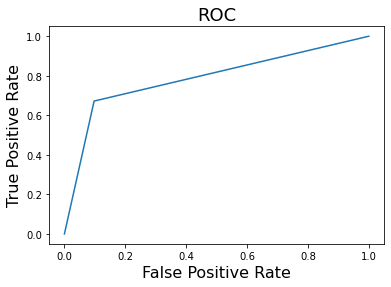

In [33]:
plot.simple_roc(y_valid, y_pred)

In [34]:
# plot.feature_importance(winner, X_train)

In [35]:
plot.decision_tree(winner, X_train)